In [1]:
%matplotlib inline
from torch.utils.data import Dataset 
import glob
import torchvision.models as models
from torchvision import transforms
from torch import nn
import torch
import torch.optim as optim
from torch.autograd import Variable
from tqdm import tqdm
import os
from skimage import io, transform
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import math
from torchvision import utils

In [2]:
width = 36
height = 64
emb_w = math.ceil(width / 4)
emb_h = math.ceil(height / 4)
np.random.seed(1)
h= 64
n = 64
lr = 0.001

In [3]:
MODEL_PATH = '/run/media/backman/yay/uiD'
MODEL2_PATH = '/run/media/backman/yay/uiG'

def save_model():
    torch.save(netD.state_dict(), MODEL_PATH)
    torch.save(netG.state_dict(), MODEL2_PATH)
    
def load_model():
    netD.load_state_dict(torch.load(MODEL_PATH))
    netG.load_state_dict(torch.load(MODEL2_PATH))

In [4]:
def resize_images():
    root_dir = '/run/media/backman/yay/unique_uis/combined/'
    new_dir = '/run/media/backman/yay/unique_uis/resized/'
    files = glob.glob(root_dir + '*.jpg')
    for file in tqdm(files):
        try:
            im = Image.open(file)
            im.thumbnail((width,height), Image.ANTIALIAS)
            assert im.size == (width,height)
            im.save(new_dir+os.path.basename(file),"JPEG")
        except IOError:
            pass
        except AssertionError:
            pass

In [5]:
#resize_images()

In [6]:
use_cuda = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
bs = 16

In [7]:
class GoogleUIDataset(Dataset):

    def __init__(self, root_dir, transform=None, max = None):
        self.root_dir = root_dir
        self.files = glob.glob(root_dir + '*.jpg')
        if max:
            self.files = np.random.permutation(self.files)[:max]
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.files[idx])
        image = io.imread(img_name)
        if self.transform:
            image = self.transform(image)
        return image

In [8]:
class Rescale(object):
    def __init__(self, output_size):
        assert isinstance(output_size, tuple)
        self.output_size = output_size

    def __call__(self, image):

        h, w = image.shape[:2]
        new_h, new_w = self.output_size
        new_h, new_w = int(new_h), int(new_w)
        img = transform.resize(image, (new_h, new_w), mode='constant')
        return img

In [9]:
g = GoogleUIDataset('/run/media/backman/yay/unique_uis/resized/',
                                                   transform=transforms.Compose([
#                                                     Rescale((36, 64)),
                                                    transforms.ToTensor(),
                                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                                   ]),
                  max=10000)
guid = torch.utils.data.DataLoader(g,
                                   bs, True, num_workers = 1)

In [10]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('ConvTranspose2d') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [11]:
class Flatten(nn.Module):
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return x
    
class Reshape(nn.Module):
    def forward(self, x):
        x = x.view(-1, 4*n, emb_h, emb_w)
        return x

In [12]:
def conv_sub_block(in_c, out_c, sub = False):
    conv_sub_arr = []
    conv_sub_arr.append(nn.Conv2d(in_c, out_c, 3, padding=1, bias=False))
    conv_sub_arr.append(nn.LeakyReLU())
#         conv_sub_arr.append(nn.Conv2d(out_c, out_c, 3, padding=1, bias=False))
#         conv_sub_arr.append(nn.ReLU())
    if sub:
        conv_sub_arr.append(nn.Conv2d(out_c, out_c, 3, stride = 2, padding=1, bias=False))
        conv_sub_arr.append(nn.LeakyReLU())
        conv_sub_arr.append(torch.nn.Dropout())
        
    conv_sub_arr.append(nn.BatchNorm2d(out_c))
    return conv_sub_arr

def deconv_up_block(in_c, out_c = None, up = False):
    if out_c is None:
        out_c = in_c
    deconv_sub_arr = []
    if up:
        deconv_sub_arr.append(nn.Dropout())

    deconv_sub_arr.append(nn.Conv2d(in_c, out_c, 3, padding=1, bias=False))
    deconv_sub_arr.append(nn.LeakyReLU())
#         deconv_sub_arr.append(nn.Conv2d(out_c, out_c, 3, padding=1, bias=False))
#         deconv_sub_arr.append(nn.ReLU())
    if up:
        deconv_sub_arr.append(nn.ConvTranspose2d(out_c, out_c, 2, 2, bias=False))
#         deconv_sub_arr.append(nn.Upsample(scale_factor = 2, mode='nearest'))
        deconv_sub_arr.append(nn.LeakyReLU())
    return deconv_sub_arr



In [13]:
class D(nn.Module):

  

    def __init__(self):
        super(D, self).__init__()

        layers = []
        layers.append(nn.Conv2d(3, n, 3, padding=1, bias=False))
        layers += conv_sub_block(n, n*2, True)
        layers += conv_sub_block(n*2, n*4, True)
#         layers += self.conv_sub_block(n*3, n*4, True)
#         layers += self.conv_sub_block(n*4, n*5, True)
#         layers += self.conv_sub_block(n*5, n*6, True)
#         layers += self.conv_sub_block(n*6, n*7, True)
        layers += conv_sub_block(n*4, n*4)
        layers.append(Flatten())
        layers.append(nn.Linear(4*emb_h*emb_w*n, h))
 
        layers.append(nn.Linear(h,emb_h*emb_w*n*4))
        layers.append(Reshape())
#         layers += self.deconv_up_block(n*7, n*6, up = True)
#         layers += self.deconv_up_block(n*6, n*5, True)
#         layers += self.deconv_up_block(n*5, n*4, True)
#         layers += self.deconv_up_block(n*4, n*3, True)
        layers += deconv_up_block(n*4, n*2, True)
        layers += deconv_up_block(n*2, n*2, True)
        layers += deconv_up_block(n*2, n)
        layers.append(nn.Conv2d(n, 3, 3, padding=1, bias=False))
        layers.append(nn.Tanh())
        
        self.model = nn.Sequential(*layers)

    def forward(self, input):
        return self.model(input)



In [14]:
class G(nn.Module):
    
    def __init__(self):
        super(G, self).__init__()

        layers = []
        layers.append(nn.Linear(h,4*emb_h*emb_w*n)) 
        layers.append(Reshape())
#         layers += self.deconv_up_block(n*7, n*6, up = True)
#         layers += self.deconv_up_block(n*6, n*5, True)
#         layers += self.deconv_up_block(n*5, n*4, True)
#         layers += self.deconv_up_block(n*4, n*3, True)
        layers += deconv_up_block(n*4, n*2, True)
        layers += deconv_up_block(n*2, n*2, True)
        layers += deconv_up_block(n*2, n)
        layers.append(nn.Conv2d(n, 3, 3, padding=1, bias=False))
        layers.append(nn.Tanh())

        self.model = nn.Sequential(*layers)

    def forward(self, input):
        return self.model(input)

In [15]:
netD = D()

In [16]:
netG = G()

In [17]:
noise = dtype(bs, 64)

In [18]:
if use_cuda:
    netG = netG.cuda()
    netD = netD.cuda()
netG.apply(weights_init)
netD.apply(weights_init)

D (
  (model): Sequential (
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (2): LeakyReLU (0.01)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (4): LeakyReLU (0.01)
    (5): Dropout (p = 0.5)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (8): LeakyReLU (0.01)
    (9): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (10): LeakyReLU (0.01)
    (11): Dropout (p = 0.5)
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (13): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (14): LeakyReLU (0.01)
    (15): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
    (16): Flatten (
    )
    (17): Linear (36864 -> 64)
   

In [19]:
optimizerG = optim.Adam(netG.parameters(), lr =lr)
optimizerD = optim.Adam(netD.parameters(), lr = lr)

In [20]:
noise = Variable(noise)
ms = []

In [21]:
def get_real_image(batch):
    var = batch
    if use_cuda:
        var = var.cuda()
    return Variable(var)

In [22]:
def get_fake_image():
    noise.data.normal_(0, 1)
    return noise

In [23]:
def show_image(net):
    example =   net(get_fake_image()).data.cpu()
    utils.make_grid(example)
    im = example / 2 +0.5
    im = im.numpy()
    plt.imshow(np.transpose(im[1], (1,2,0)))

In [24]:
def adjust_learning_rate(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [25]:
def make_trainable(net, val): 
    for p in net.parameters(): p.requires_grad = val

In [26]:
def train(n_epochs = 1, k_t = 0, lambda_k = 0.001, gamma = 0.5):
    n_batches = len(guid)
    for epoch in tqdm(range(n_epochs)):
        data_iter = iter(guid)
        step = 0
        n = len(guid)
        while step < n:
            max_D_train = 5 if n - step >= 5 else 1 
#             for _ in range(max_D_train):
            image = next(data_iter)
            step += 1
            #real image
            real = get_real_image(image)
            netD.zero_grad()
            loss_real = torch.mean(torch.abs(netD(real) - real))

            #fake image
            fake = netG(get_fake_image())
            loss_fake = torch.mean(torch.abs(netD(fake) - fake))
            loss_discriminator = loss_real - k_t * loss_fake
            loss_discriminator.backward()
            optimizerD.step()

            make_trainable(netD, False)

            netG.zero_grad()
            #discriminator should not be trainable here
            fake = get_fake_image()
            loss_generator = torch.mean(torch.abs(netG(fake) - netD(netG(fake))))
            loss_generator.backward()
            optimizerG.step()
            
            update = gamma * loss_real - loss_generator
            m = loss_real + update
            update = update.data[0]
            
            k_t += lambda_k * update 
            k_t = max(min(1, k_t), 0)#bout ingore?
            
            make_trainable(netD, True)
            
        m = m.data[0]
        ms.append(m)
        
        if epoch % 5 == 0 or epoch == n_epochs - 1:
            print(f'loss_generator: {loss_generator.data[0]};\
                  m: {m};\
                  loss_discriminator:  {loss_discriminator.data[0]}')
                
    return k_t
                
            
            
                
        

In [27]:
k_t = train()

100%|██████████| 1/1 [01:50<00:00, 110.58s/it]

loss_generator: 0.10315725207328796;                  m: 0.22952982783317566;                  loss_discriminator:  0.22176089882850647


In [28]:
#load_model()

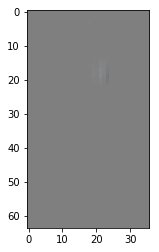

In [29]:
show_image(netG)

In [30]:
k_t = train(2, k_t)

 50%|█████     | 1/2 [01:53<01:53, 113.58s/it]

loss_generator: 0.1058863177895546;                  m: 0.1688733696937561;                  loss_discriminator:  0.18317312002182007


100%|██████████| 2/2 [03:47<00:00, 113.66s/it]

loss_generator: 0.11051622778177261;                  m: 0.20991960167884827;                  loss_discriminator:  0.21356049180030823


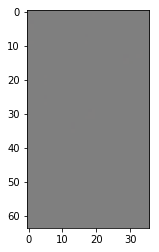

In [31]:
show_image(netG)

In [32]:
k_t = train(5, k_t)

 20%|██        | 1/5 [01:53<07:35, 113.98s/it]

loss_generator: 0.12397450953722;                  m: 0.2046774923801422;                  loss_discriminator:  0.21908731758594513


100%|██████████| 5/5 [09:25<00:00, 113.14s/it]

loss_generator: 0.07378298044204712;                  m: 0.16960525512695312;                  loss_discriminator:  0.16225391626358032


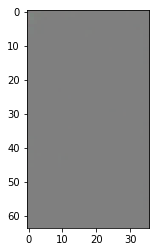

In [33]:
show_image(netG)

In [ ]:
#save_model()

In [ ]:
lr = lr / 2
adjust_learning_rate(optimizerD,lr)
adjust_learning_rate(optimizerG,lr)
k_t = train(5, k_t)

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
show_image(netG)

In [ ]:
k_t = train(100, k_t)

In [ ]:
show_image(netG)

In [ ]:
lr = lr / 2
optimizerG = optim.Adam(netG.parameters(), lr = lr)
optimizerD = optim.Adam(netD.parameters(), lr = lr)
k_t = train(100, k_t)
lr = lr / 2
optimizerG = optim.Adam(netG.parameters(), lr = lr)
optimizerD = optim.Adam(netD.parameters(), lr = lr)
k_t = train(100, k_t)
lr = lr / 2
optimizerG = optim.Adam(netG.parameters(), lr = lr)
optimizerD = optim.Adam(netD.parameters(), lr = lr)
k_t = train(100, k_t)

In [ ]:
show_image(netG)

In [ ]:
lr = lr / 2
optimizerG = optim.Adam(netG.parameters(), lr = lr)
optimizerD = optim.Adam(netD.parameters(), lr = lr)
k_t = train(200, k_t)
lr = lr / 2
optimizerG = optim.Adam(netG.parameters(), lr = lr)
optimizerD = optim.Adam(netD.parameters(), lr = lr)
k_t = train(200, k_t)
lr = lr / 2
optimizerG = optim.Adam(netG.parameters(), lr = lr)
optimizerD = optim.Adam(netD.parameters(), lr = lr)
k_t = train(200, k_t)

In [ ]:
show_image(netG)

In [ ]:
lr = lr / 2
optimizerG = optim.Adam(netG.parameters(), lr = lr)
optimizerD = optim.Adam(netD.parameters(), lr = lr)
k_t = train(200, k_t)

In [ ]:
show_image(netG)